# ANLY 590 Assignment 1

## 1 Regularization
Using the accompanying Hitters dataset, we will explore 
regression models to predict a player’s Salary from other variables. You must python.
https://gist.github.com/keeganhines/59974f1ebef97bbaa44fb19143f90bad

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import dataset
hitter = pd.read_csv("Hitters.csv")

# Drop the unnamed column
hitter = hitter.loc[:, ~hitter.columns.str.contains('^Unnamed')]

#### Run basic data exploration

In [3]:
# Check dataframe shape
print("Hitters dataset has", hitter.shape[0], "rows and", hitter.shape[1], "columns.\n")

# Counr na rows in the dataframe
print("Hitters dataset na rows:\n", hitter.isna().sum())

# Get summary of dataframe
print("\nHitters dataset summary:\n",hitter.describe())

# Get types of each predictor
hitter.dtypes

Hitters dataset has 322 rows and 20 columns.

Hitters dataset na rows:
 AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

Hitters dataset summary:
             AtBat        Hits       HmRun        Runs         RBI       Walks  \
count  322.000000  322.000000  322.000000  322.000000  322.000000  322.000000   
mean   380.928571  101.024845   10.770186   50.909938   48.027950   38.742236   
std    153.404981   46.454741    8.709037   26.024095   26.166895   21.639327   
min     16.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
25%    255.250000   64.000000    4.000000   30.250000   28.000000   22.000000   
50%    379.500000   96.000000    8.000000   48.000000   44.000000   35.000000   
7

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

In [4]:
# Drop na rows, since salary is the response variable
hitter = hitter.dropna()

In [5]:
# Drop response variable and categorical predictors
hitter_pred= hitter.drop(['Salary','League', 'Division', 'NewLeague'], axis=1)

# Prepare response variable
hitter_y = hitter['Salary']

In [6]:
# Normalize the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(hitter_pred))
hitter_X = scaler.transform(hitter_pred)

StandardScaler(copy=True, with_mean=True, with_std=True)


## 1.1
Use LASSO regression to predict Salary from the other numeric predictors.
Create a visualization of the coefficient trajectories. Comment on which are the
final three predictors that remain in the model. Use cross-validation to find the
optimal value of the regularization penality. How many predictors are left in
that model?

In [7]:
# Import libraries
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV

In [8]:
lasso = Lasso(normalize = True, max_iter = 10000)

In [9]:
lasso.fit(hitter_X, hitter_y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [10]:
# Create visualization of the coefficient trajectories
alphas_lasso, coefs_lasso, _ = lasso_path(hitter_X, hitter_y, 5e-4, fit_intercept = False)

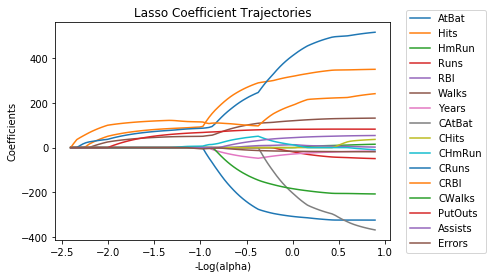

In [11]:
# Create visualization for Lasso coefficient trajectories
plt.figure()

neg_log_alphas_lasso = -np.log10(alphas_lasso)

for coef_l in coefs_lasso:
    l1 = plt.plot(neg_log_alphas_lasso, coef_l)
plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficient Trajectories')
plt.legend(hitter_pred.columns.tolist(), loc = 'center right', bbox_to_anchor=(1.3, 0.5))


In [12]:
# Use for loop to print out the last three coefficients
for i in range(len(coefs_lasso[0])):
    if len([elem for elem in [item[i] for item in coefs_lasso] if elem != 0]) == 3:
        coef_list = [item[i] for item in coefs_lasso]

# Print out the position index of the last three coefficients
coef_idx = [idx for idx, val in enumerate(coef_list) if val != 0] 

#Print out the predictors based on the indices
list(hitter_pred.columns[coef_idx])

['Hits', 'CRuns', 'CRBI']

The final three predictors that remain in the model are 'Hits', 'CRuns', 'CRBI'.

In [13]:
# Use GridSearchCV to find the optimal value of the regularization penality

# n_folds = 10
# parameters = {'alpha': np.arange(-100, 100, 0.1)}
# lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = n_folds)
# lasso_regressor.fit(hitter_X, hitter_y)

# print(lasso_regressor.best_params_)
# print(lasso_regressor.best_score_)


In [14]:
# Use LassoCV to find the optimal value of the regularization penality
lasso_cv = LassoCV(cv = 10, random_state = 0).fit(hitter_X, hitter_y)
lasso_alpha = lasso_cv.alpha_

# Find the number of predictors that are left in that model
lasso_remain = len([item for item in lasso_cv.coef_ if item !=0])

print("The optimal value of the lasso regularization penality is", str(lasso_alpha) + ", \nand", 
      lasso_remain, "predictors are left in that model")

The optimal value of the lasso regularization penality is 0.9611207059719769, 
and 15 predictors are left in that model


## 1.2
Repeat with Ridge Regression. Visualize coeffecient trajectories. Use crossvalidation to find the optimal vaule of the regularization penalty.

In [15]:
# Import libraries
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [16]:
# Compute paths
n_alphas = 200
alphas = np.logspace(-10, 5, n_alphas)

ridge_coefs = []
for elem in alphas:
    ridge = Ridge(alpha = elem, fit_intercept = False)
    ridge.fit(hitter_X, hitter_y)
    ridge_coefs.append(ridge.coef_)


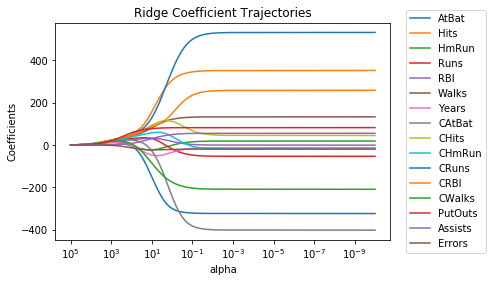

In [17]:
# Create visualization for Ridge coefficient trajectories
ax = plt.gca()

ax.plot(alphas, ridge_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # Reverse axis
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficient Trajectories')
plt.legend(hitter_pred.columns.tolist(), loc = 'center right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [18]:
# Use RidgeCV to find the optimal value of the regularization penality
ridge_cv = RidgeCV(alphas = alphas, cv = 10).fit(hitter_X, hitter_y)
ridge_alpha = ridge_cv.alpha_

# Find the number of predictors that are left in that model
ridge_remain = len([item for item in ridge_cv.coef_ if item !=0])

print("The optimal value of the ridge regularization penality is", str(ridge_alpha) + ", \nand", 
      ridge_remain, "predictors are left in that model")

The optimal value of the ridge regularization penality is 230.04301197729123, 
and 16 predictors are left in that model


## 2 
__Short Answer__. Explain in your own words the bias-variance tradeoff. What
role does regularization play in this tradeoff? Make reference to your findings
in number (1) to describe models of high/low bias and variance.

The bias-variance tradeoff is a common term in statistical learning and machine learning. Variance refers to the amount of change in targeting variables when new data set is being used. Bias refers to the error when predicting using new data. And the bias-variance tradeoff means as the model becomes more flexible, the variance will increase and bias will decrease, which means if one wants to decrease bias, he/she must also sacrifices some variance, and vice versa. And there will exist an optimal point, where both the bias and the variance are low.  

Regularization can significantly reduce variance as it shrinks the corfficient estimates. It reduces variance by add a shrinkage penalty term, so that the coefficient estimates can be constrained or regularized. 

From the result in part1, as the shrinkage penalty grows, the ridge regression coefficient estimates will approach zero and lasso regression coefficient estimates will become zero and thus regularize the model, and the bias stars to increase while the variance starts to decrease. By using LassoCV and RidgeCV, we can find the optimal value of regularization penality, after that point the the variance may keep decreasing but bias may become extramely large.